# Calibration

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

Calibration of a machine learning model involves making little but meaningful changes to the model's predictions in order to improve both accuracy and confidence in those predictions. Specifically, the goal of model calibration is to make that the model's anticipated probabilities are consistent with reality.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import shap
import warnings
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from matplotlib.pyplot import figure
from matplotlib import image as mpimg
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import JamesSteinEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from lime.lime_tabular import LimeTabularExplainer
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [3]:
from preprocessing import *

In [4]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
def compute_auc(y, y_pred):

    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label = 1)

    return metrics.auc(fpr, tpr)

In [6]:
def calibration(y, y_pred):

    scores, probs = calibration_curve(y, y_pred, n_bins = 10, normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
    plt.plot(probs, scores, marker = '.', label = 'Real Calibration')
 
    leg = plt.legend(loc = 'upper left')

    plt.xlabel('Probability on each bin')
    plt.ylabel('Real probability on each bin')

    plt.title('Calibration')
    plt.show()

In [7]:
def predict_proba(X):
    return clf.predict_proba(X)[:, 1]

In [8]:
!pip install -q xgboost

In [9]:
start = time.time()

# 1. Train the model

In [10]:
df = pd.read_csv('credit_risk.csv')

In [11]:
cat_str = ['person_home_ownership', 'loan_intent']
cat_oh = ['cb_person_default_on_file', 'loan_grade']

num_mean = ['person_age', 'person_income', 'loan_percent_income']
num_zero = ['cb_person_cred_hist_length']

num_mean_nan = ['loan_int_rate', 'person_emp_length']
num_zero_nan = ['loan_amnt']

X_cols = cat_str + cat_oh + num_mean + num_zero + num_mean_nan + num_zero_nan

label = 'loan_status'

In [12]:
features_dict = {
    'cat_str': cat_str,
    'cat_oh': cat_oh,
    'num_mean': num_mean,
    'num_zero': num_zero,
    'num_mean_nan': num_mean_nan,
    'num_zero_nan': num_zero_nan
}

In [13]:
X = df[X_cols].copy()
y = df[label].copy()

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.40, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 10)

In [15]:
transformers_pre = get_fit_transfomers(features_dict, X_train, y_train)

In [16]:
y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])

y_val = y_val.reset_index()
y_val = y_val.drop(columns = ['index'])

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ['index'])

In [17]:
X_train = transform_datasets(transformers_pre, features_dict, X_train)

X_val = transform_datasets(transformers_pre, features_dict, X_val)

X_test = transform_datasets(transformers_pre, features_dict, X_test)

In [18]:
clf = XGBClassifier(n_estimators = 60, max_depth = 7)

In [19]:
clf = clf.fit(X_train, y_train)

In [20]:
y_train_pred = clf.predict_proba(X_train)[:, 1]

y_val_pred = clf.predict_proba(X_val)[:, 1]

y_test_pred = clf.predict_proba(X_test)[:, 1]

In [21]:
y_train_pred = (y_train_pred >= 0.2)*1

y_val_pred = (y_val_pred >= 0.2)*1

y_test_pred = (y_test_pred >= 0.2)*1

In [22]:
r_train = recall_score(y_train, y_train_pred)

r_val = recall_score(y_val, y_val_pred)

r_test = recall_score(y_test, y_test_pred)

In [23]:
print('Recall Train:', round(r_train*100, 2))

print('Recall Val:', round(r_val*100, 2))

print('Recall Test:', round(r_test*100, 2))

Recall Train: 93.49
Recall Val: 83.97
Recall Test: 85.3


In [24]:
y_train_pred = clf.predict_proba(X_train)[:, 1]

y_val_pred = clf.predict_proba(X_val)[:, 1]

y_test_pred = clf.predict_proba(X_test)[:, 1]

# 2. Calibration

### i. Display plots

The plots order groups in ascending order of probability predicted. For this reason x-label represents the probability and the y-label represents the real probability measure on those groups.

**a. Train**

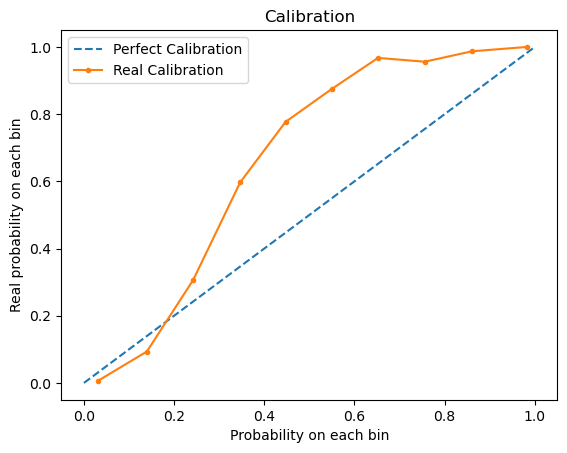

In [25]:
calibration(y_train, y_train_pred)

**b. Validation**

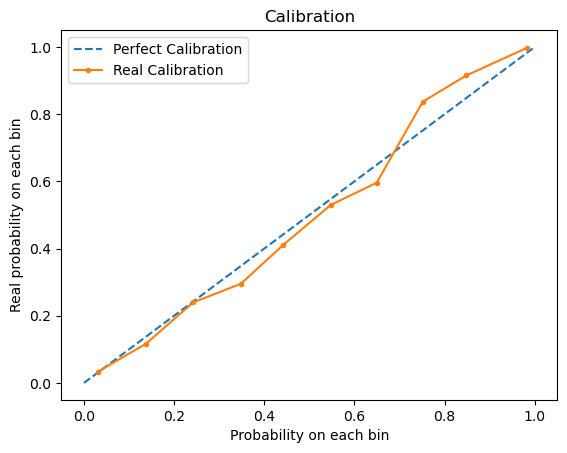

In [26]:
calibration(y_val, y_val_pred)

**c. Test**

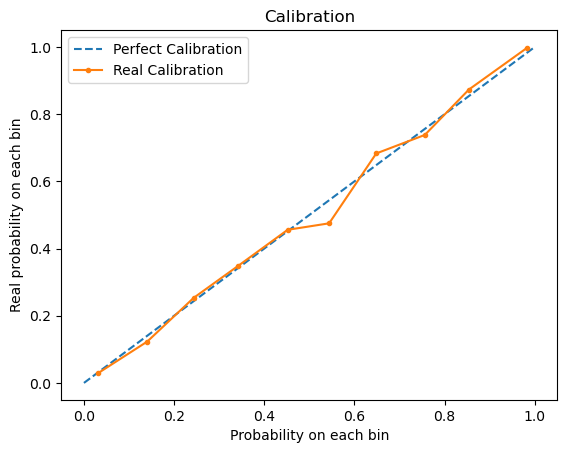

In [27]:
calibration(y_test, y_test_pred)

**Comments:** As you can see the probabilities are already well calibrated and this is because XGBoost has a previous calibrator.

In [28]:
X_val['prob'] = y_val_pred
X_val['real'] = y_val

In [29]:
X_test['prob'] = y_test_pred
X_test['real'] = y_test

### ii. Train a calibrator (Isotonic Regression)

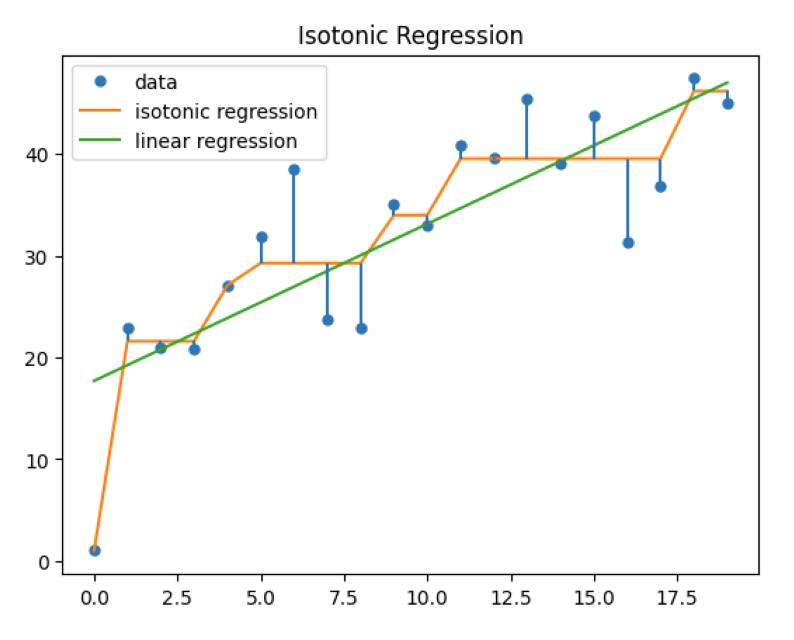

In [30]:
display_img('Isotonic_Regression.png', 10, 10)

In [31]:
from sklearn.isotonic import IsotonicRegression

In [32]:
iso_reg = IsotonicRegression().fit(X_val[['prob']], X_val['real'])

**a. Validation**

In [33]:
X_val['prob_cal_iso'] = iso_reg.predict(X_val[['prob']])

In [34]:
f_val_iso = X_val['prob_cal_iso'].notna()

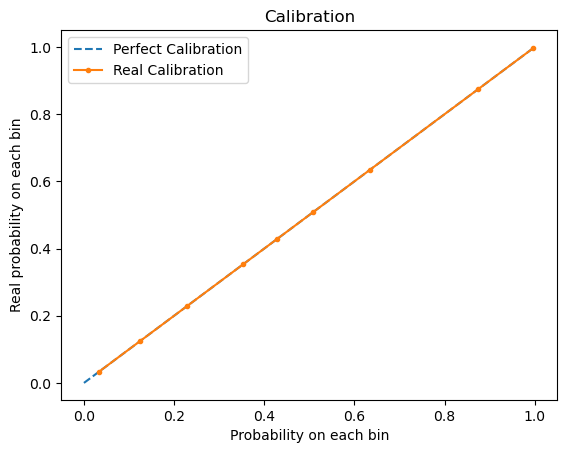

In [35]:
calibration(X_val[f_val_iso]['real'], X_val[f_val_iso]['prob_cal_iso'])

**b. Test**

In [36]:
X_test['prob_cal_iso'] = iso_reg.predict(X_test[['prob']])

In [37]:
f_test_iso = X_test['prob_cal_iso'].notna()

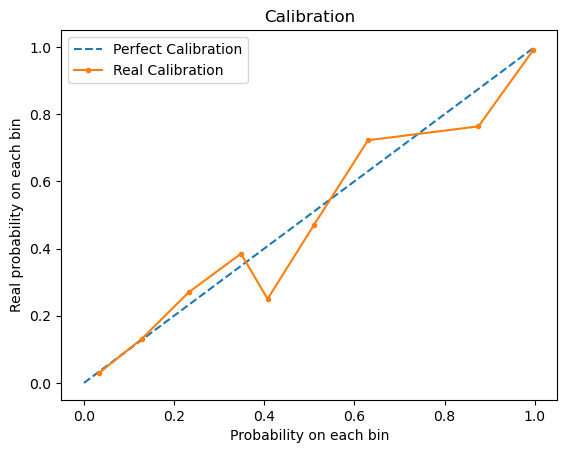

In [38]:
calibration(X_test[f_test_iso]['real'], X_test[f_test_iso]['prob_cal_iso'])

### iii. Train a calibrator (Logistic Regression)

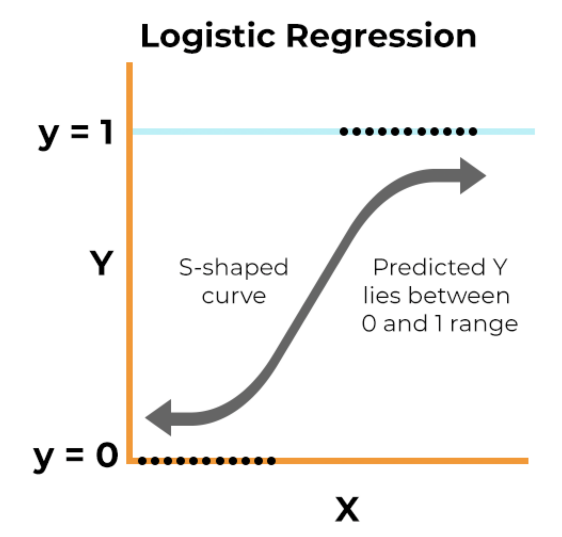

In [39]:
display_img('Logistic_Regression.png', 7, 7)

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
log_reg = LogisticRegression().fit(X_val[['prob']], X_val['real'])

**a. Validation**

In [42]:
X_val['prob_cal_log'] = log_reg.predict(X_val[['prob']])

In [43]:
f_val_log = X_val['prob_cal_log'].notna()

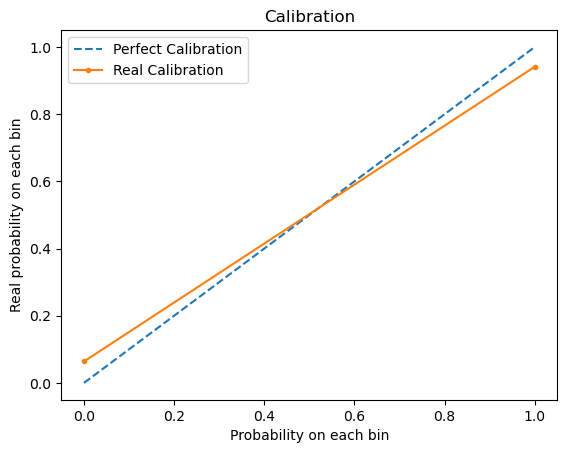

In [44]:
calibration(X_val[f_val_log]['real'], X_val[f_val_log]['prob_cal_log'])

**b. Test**

In [45]:
X_test['prob_cal_log'] = log_reg.predict(X_test[['prob']])

In [46]:
f_test_log = X_test['prob_cal_log'].notna()

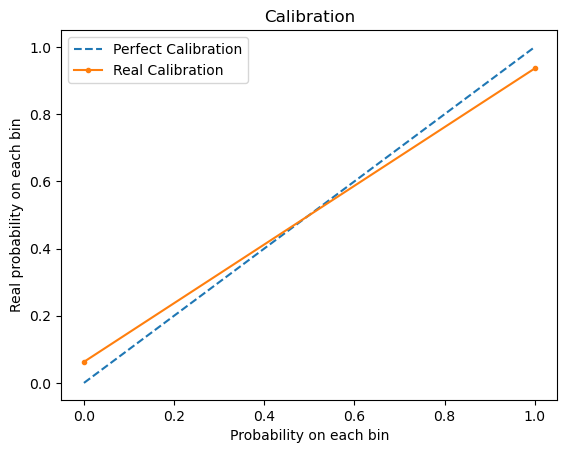

In [47]:
calibration(X_test[f_test_log]['real'], X_test[f_test_log]['prob_cal_log'])

### iv. Confidence interval

We will choose the probabilities with-out post trained calibrator because the probabilities gives us XGBoost are already well calibrated.

When we have the probabilities $(MP)$ given by a model and the real probabilities $(RP)$ we can define the next random variable:

$ e = RP - MP $

When we have $n$ observations we have:

$ e_i = RP_i - MP_i \ \forall i \in \lbrace 1, ..., n \rbrace $

We can compute $ S $ and $ \bar{e} $ as follows:

$ \bar{e} = \frac{1}{n} \sum_{i=1}^n e_i $

$ S = \sqrt{\cfrac{1}{(n-1)} \cdot \sum_{i=1}^n (e_i - \bar{e})^2} $

Asumming $ e \sim Normal $ we can say that:

$ \bar{e} - S \cdot 1.96 + MP_i \leq RP_i \leq \bar{e} + S \cdot 1.96 + MP_i $     $ \forall i \in \lbrace 1, ..., n \rbrace$  with $ 95 \% $ of confidence.

And also:

$ \bar{e} - \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} \leq \bar{RP} \leq \bar{e} + \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} $  with $ 95 \% $ of confidence.

**a. Estimate S and bar_e**

In [48]:
real_probs_val, model_probs_val = calibration_curve(y_val, y_val_pred, n_bins = 100, normalize = True)

In [49]:
df_ci_val = pd.DataFrame(zip(model_probs_val, real_probs_val))
df_ci_val = df_ci_val.rename(columns = {0: 'model_prob', 1: 'real_prob'})
df_ci_val['error'] = df_ci_val['real_prob'] - df_ci_val['model_prob']

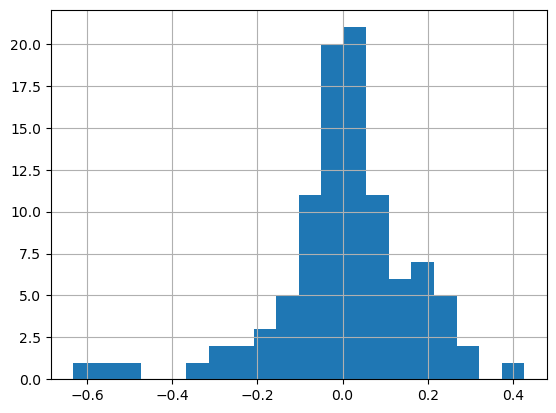

In [50]:
df_ci_val['error'].hist(bins = 20)
plt.show()

**Comments:** The distribution are very similar to a Normal.

In [51]:
bar_e = df_ci_val['error'].mean()
S = df_ci_val['error'].std()

In [52]:
round(bar_e*100, 2), round(S*100, 2)

(0.23, 16.62)

In [53]:
prob_sup = bar_e + (S)*1.96
prob_inf = bar_e - (S)*1.96

In [54]:
round(prob_sup*100, 2), round(prob_inf*100, 2)

(32.8, -32.34)

In [55]:
df_ci_val['model_prob_sup'] = df_ci_val['model_prob'] + prob_sup
df_ci_val['model_prob_inf'] = df_ci_val['model_prob'] + prob_inf

In [56]:
df_ci_val['model_prob_sup'] = df_ci_val['model_prob_sup'].map(lambda x: min([x, 1]))
df_ci_val['model_prob_inf'] = df_ci_val['model_prob_inf'].map(lambda x: max([x, 0]))

**Confidence interval for each value:**

$ \bar{e} - S \cdot 1.96 + MP_i \leq RP_i \leq \bar{e} + S \cdot 1.96 + MP_i $

In [57]:
round((((df_ci_val['model_prob_inf'] <= df_ci_val['real_prob']) & (df_ci_val['real_prob'] <= df_ci_val['model_prob_sup'])).sum()/len(df_ci_val))*100, 2)

95.0

**Confidence interval for the mean:**

$ \bar{e} - \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} \leq \bar{RP} \leq \bar{e} + \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} $

In [58]:
round((bar_e - (S/10)*1.96)*100, 2), round((bar_e + (S/10)*1.96)*100, 2)

(-3.03, 3.49)

In [59]:
round((model_probs_val.mean() + bar_e - (S/10)*1.96)*100, 2), round((model_probs_val.mean() + bar_e + (S/10)*1.96)*100, 2)

(46.97, 53.48)

In [60]:
round(real_probs_val.mean()*100, 2)

50.23

**Confidence interval for the mean of all the validation set:**

In [61]:
N_val = len(X_val)

In [62]:
round((bar_e - (S/(N_val**(1/2)))*1.96 + X_val['prob'].mean())*100, 2), round((bar_e + (S/(N_val**(1/2)))*1.96 + X_val['prob'].mean())*100, 2)

(21.53, 22.34)

In [63]:
round(X_val['real'].mean()*100, 2)

21.73

**b. Check in Test**

In [64]:
real_probs_test, model_probs_test = calibration_curve(y_test, y_test_pred, n_bins = 100, normalize = True)

In [65]:
df_ci_test = pd.DataFrame(zip(model_probs_test, real_probs_test))
df_ci_test = df_ci_test.rename(columns = {0: 'model_prob', 1: 'real_prob'})
df_ci_test['error'] = df_ci_test['real_prob'] - df_ci_test['model_prob']

In [66]:
df_ci_test['model_prob_sup'] = df_ci_test['model_prob'] + prob_sup
df_ci_test['model_prob_inf'] = df_ci_test['model_prob'] + prob_inf

In [67]:
df_ci_test['model_prob_sup'] = df_ci_test['model_prob_sup'].map(lambda x: min([x, 1]))
df_ci_test['model_prob_inf'] = df_ci_test['model_prob_inf'].map(lambda x: max([x, 0]))

**Confidence interval for each value:**

$ \bar{e} - S \cdot 1.96 + MP_i \leq RP_i \leq \bar{e} + S \cdot 1.96 + MP_i $

In [68]:
round((((df_ci_test['model_prob_inf'] <= df_ci_test['real_prob']) & (df_ci_test['real_prob'] <= df_ci_test['model_prob_sup'])).sum()/len(df_ci_test))*100, 2)

93.94

**Confidence interval for the mean:**

$ \bar{e} - \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} \leq \bar{RP} \leq \bar{e} + \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} $

In [69]:
round((model_probs_test.mean() + bar_e - (S/10)*1.96)*100, 2), round((model_probs_test.mean() + bar_e + (S/10)*1.96)*100, 2)

(46.92, 53.43)

In [70]:
round(real_probs_test.mean()*100, 2)

51.74

**Confidence interval for the mean of all the test set:**

In [71]:
N_test = len(X_test)

In [72]:
round((bar_e - (S/(N_test**(1/2)))*1.96 + X_test['prob'].mean())*100, 2), round((bar_e + (S/(N_test**(1/2)))*1.96 + X_test['prob'].mean())*100, 2)

(21.73, 22.54)

In [73]:
round(X_test['real'].mean()*100, 2)

21.82

# 3. Calibrated Classiffier

This makes training and calibration together.

In [74]:
from sklearn.calibration import CalibratedClassifierCV

In [75]:
clf = XGBClassifier(n_estimators = 60, max_depth = 7)
clf = CalibratedClassifierCV(clf, method = 'sigmoid', cv = 5)

In [76]:
clf = clf.fit(X_train, y_train)

In [77]:
y_train_pred = clf.predict_proba(X_train)[:, 1]

y_val_pred = clf.predict_proba(X_val[X_train.columns])[:, 1]

y_test_pred = clf.predict_proba(X_test[X_train.columns])[:, 1]

In [78]:
y_train_pred = (y_train_pred >= 0.2)*1

y_val_pred = (y_val_pred >= 0.2)*1

y_test_pred = (y_test_pred >= 0.2)*1

In [79]:
r_train = recall_score(y_train, y_train_pred)

r_val = recall_score(y_val, y_val_pred)

r_test = recall_score(y_test, y_test_pred)

In [80]:
print('Recall Train:', round(r_train*100, 2))

print('Recall Val:', round(r_val*100, 2))

print('Recall Test:', round(r_test*100, 2))

Recall Train: 92.62
Recall Val: 81.5
Recall Test: 82.77


In [81]:
y_train_pred = clf.predict_proba(X_train)[:, 1]

y_val_pred = clf.predict_proba(X_val[X_train.columns])[:, 1]

y_test_pred = clf.predict_proba(X_test[X_train.columns])[:, 1]

**a. Train**

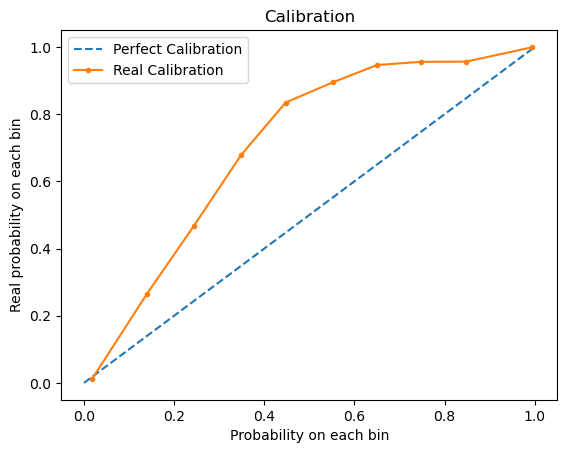

In [82]:
calibration(y_train, y_train_pred)

**b. Validation**

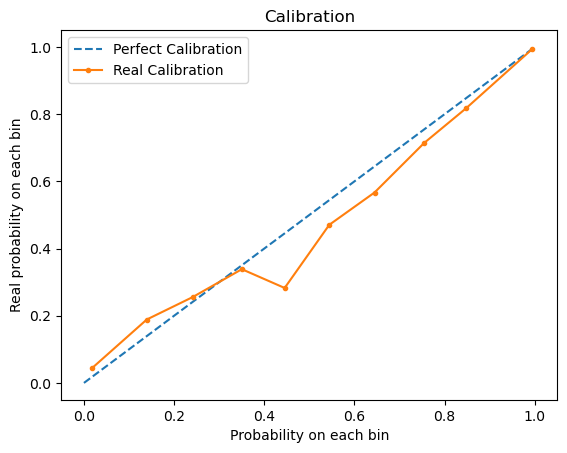

In [83]:
calibration(y_val, y_val_pred)

**c. Test**

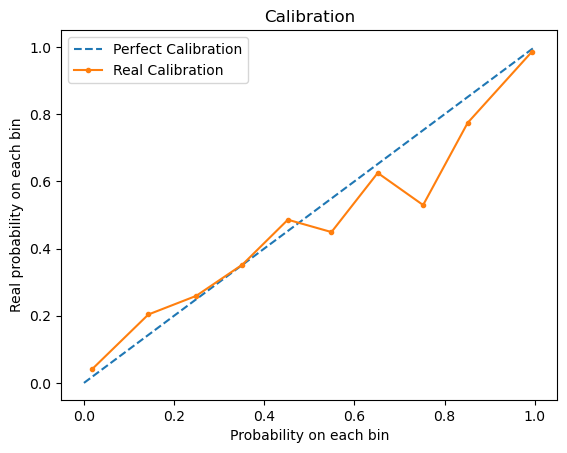

In [84]:
calibration(y_test, y_test_pred)

### Time of execution

In [85]:
end = time.time()

In [86]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 3 seconds.
